In [1]:
import sys
sys.path.append('../')
from initial_classif.classifier.classifier import binary_classification
from fine_classif.feat_extract.compute_feats import correct_to_HJD, sigclipper
import pickle
import glob
import sqlutilpy as sqlutil
from config import configuration

from astropy.utils.iers import IERS_A_URL, IERS_B_URL, conf
from astropy.utils.data import download_file

conf.auto_download = True
download_file(IERS_A_URL, cache="update")
download_file(IERS_B_URL, cache="update")
conf.auto_download = False

config = configuration()
config.request_password()

/home/jls/.local/lib/python3.5/site-packages/xgboost/__init__.py:29: FutureWarning: Python 3.5 support is deprecated; XGBoost will require Python 3.6+ in the near future. Consider upgrading to Python 3.6+.
  FutureWarning)


 ·············


In [2]:
with open('/local/scratch_2/jls/virac_classifier/variable/edr3/variable_classifier.pkl', 'rb') as f:
    var = pickle.load(f)
with open('/local/scratch_2/jls/virac_classifier/variable/edr3/variable_training_set.pkl', 'rb') as f:
    var_dataset_scaled = pickle.load(f)
with open('/local/scratch_2/jls/virac_classifier/variable/edr3/variable_features_total.pkl', 'rb') as f:
    var_dataset_full = pickle.load(f)
with open('/local/scratch_2/jls/virac_classifier/variable/edr3/variable_features_mira.pkl', 'rb') as f:
    mira_features = pickle.load(f)
var_dataset_full = pd.concat([var_dataset_full, mira_features], axis=0)
var_dataset = var_dataset_full.merge(var_dataset_scaled[['sourceid', 'class', 'prob']], on='sourceid')
var_dataset_full = var_dataset_full[(~var_dataset_full['error'])].reset_index(drop=True)

/data/jls/python3.5/site-packages/ipykernel_launcher.py:9: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  if __name__ == '__main__':


In [3]:
def Fmodel(S, ii, phase):
    mag = np.zeros_like(phase)
    for jj in range(4):
        mag+=S['amp_%i'%jj].values[ii]*np.cos((jj+1)*phase+S['phi_%i'%jj].values[ii])
    return mag
def plot_Fmodel(ii,scale=1,color='k'):
    phase = np.linspace(0.,2.*np.pi)
    mag=Fmodel(ii, phase)
    plt.plot(phase/(2.*np.pi)*S['lsq_period'][ii], scale*mag, color=color)

In [4]:
def sigclipper(x, sig_thresh=5):
    stdd = .5 * np.diff(np.nanpercentile(x, [16, 84]))
    midd = np.nanmedian(x)
    return (np.abs(x - midd) / stdd < sig_thresh)

In [36]:
from scipy.optimize import minimize

In [159]:
def compute_amplitudes(typee = 'Ell', fltr=None, Nlimit=300):
    
    if fltr is not None:
        ell_sid=var_dataset['sourceid'][(var_dataset['var_class']==typee)&(var_dataset['log10_fap_ls']<-10)&fltr].values
    else:
        ell_sid=var_dataset['sourceid'][(var_dataset['var_class']==typee)&(var_dataset['log10_fap_ls']<-10)].values

    S=pd.DataFrame(sqlutil.local_join('''select t.sourceid from t 
                                         inner join leigh_smith.virac2_ts_tmolnar as v 
                                         on v.sourceid=t.sourceid''',
                      't', (ell_sid,), ('sourceid',),**config.wsdb_kwargs))
    S = pd.merge(S, var_dataset[(var_dataset['var_class']==typee)].reset_index(drop=True), on='sourceid').reset_index(drop=True)
    S = S.sort_values(by='sourceid').reset_index(drop=True)
    
    print(len(S))
    
    if(len(S)>Nlimit):
        S = S.iloc[:Nlimit].reset_index(drop=True)

    ss = pd.DataFrame(sqlutil.get('''select sourceid, 
                                    unnest(mjdobs) as mjdobs,
                                    unnest(mag) as mag,
                                    unnest(ast_res_chisq) as ast_res_chisq,
                                    unnest(ambiguous_match) as ambiguous_match,
                                    unnest(chi) as chi,
                                    unnest(filterid) as fid,
                                    unnest(emag) as error from leigh_smith.virac2_ts_tmolnar 
                                    where sourceid in (%s);'''%(','.join([str(s) for s in S['sourceid'].values])),
                                           **config.wsdb_kwargs))

    ss = ss[(ss['mag']>0.)&(ss['ast_res_chisq']<11.829)&(ss['ambiguous_match']==0)].reset_index(drop=True)
    ss = ss.sort_values(by='sourceid').reset_index(drop=True)

    ss = ss.groupby('sourceid', sort=True)    
    gk = list(ss.groups.keys())
    gk.sort()
    ss=[ss.get_group(x) for x in gk]

    [correct_to_HJD(sss, S['ra'].values[ii], S['dec'].values[ii]) for ii,sss in enumerate(ss)];
    
    ivw_ = lambda m, e: np.nansum(m/e**2)/np.nansum(1./e**2)
    
    def contemp_mag_scatter_ratio(lc, filter_id, filter_id_ref=5, tthresh=1./24.):
        
        Jtimes = lc['HJD'].values[lc['fid']==filter_id]
        Jmag = lc['mag'].values[lc['fid']==filter_id]
        Jmag_err = lc['error'].values[lc['fid']==filter_id]
        meanJ = ivw_(Jmag,Jmag_err)
        
        Ktimes = lc['HJD'].values[lc['fid']==filter_id_ref]
        Kmag = lc['mag'].values[lc['fid']==filter_id_ref]
        Kmag_err = lc['error'].values[lc['fid']==filter_id_ref]
        meanK = ivw_(Kmag,Kmag_err)
        
        tdiffs = np.abs(Jtimes[:,np.newaxis] - Ktimes[np.newaxis,:])
        tmin = np.min(tdiffs, axis=1)
        tamin = np.argmin(tdiffs, axis=1)

        fltrT = (tmin<tthresh)
        mean_k_err = np.nanmedian(Kmag_err[tamin][fltrT])
        mean_j_err = np.nanmedian(Jmag_err[fltrT])
        
        Jscatter = ivw_((Jmag[fltrT]-meanJ)**2,Jmag_err[fltrT]) - mean_j_err**2
        Kscatter = ivw_((Kmag[tamin][fltrT]-meanK)**2,Kmag_err[tamin][fltrT]) - mean_k_err**2

        return np.sqrt(Jscatter / Kscatter)

    def data_scatter_wrt_model(lc, amplitudes, phases, period):
        
        phase = (lc['HJD'] % period) * (2. * np.pi) / period
        n = np.arange(1, len(amplitudes)+1)
        mag = np.sum(amplitudes[:,np.newaxis] * np.cos(n[:,np.newaxis]*phase[np.newaxis,:]+phases[:,np.newaxis]), axis=0)
        
        meanJ = ivw_(lc['mag'].values,lc['error'].values)
        meanK = ivw_(mag,lc['error'].values)
        mean_err = np.nanmedian(lc['error'].values)
        
        Jscatter = ivw_((lc['mag'].values-meanJ)**2,lc['error'].values) - mean_err**2
        Kscatter = ivw_((mag-meanK)**2, lc['error'].values)
        
        if len(lc['mag'].values)>2:
            params=leastsq(lambda p: (mag*p[1]**2-(lc['mag'].values+meanK)-p[0])/lc['error'].values, [0.,1.])[0]
            spread = np.sqrt(params[1])
        else:
            spread=np.nan
        
        return np.sqrt(Jscatter / Kscatter), spread
    
    def find_amplitudes(ii):
    
        rslt=np.zeros(9)
        for jj in range(3,6)[::-1]:
            
            rslt[5-jj], rslt[5-jj+6]=data_scatter_wrt_model(ss[ii][ss[ii]['fid']==jj],
                                              np.array([S['amp_%i'%kk].values[ii] for kk in range(4)]),
                                              np.array([S['phi_%i'%kk].values[ii] for kk in range(4)]),
                                              S['lsq_period'].values[ii])

            
            rslt[5-jj+3]=contemp_mag_scatter_ratio(ss[ii], jj)
            
        return rslt
    
    return np.array([find_amplitudes(ii) for ii in range(len(S))]), S

In [ ]:
rslts_RRab, S_RRab = compute_amplitudes(typee='RRab')
rslts_Ell, S_Ell = compute_amplitudes()
rslts_RRc, S_RRc = compute_amplitudes(typee='RRc')
rslts_EW, S_EW = compute_amplitudes(typee='EW')
rslts_EAB, S_EAB = compute_amplitudes(typee='EA/EB')
rslts_T2C, S_T2C = compute_amplitudes(typee='T2CEP')

1155


/data/jls/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in sqrt
/data/jls/python3.5/site-packages/ipykernel_launcher.py:87: RuntimeWarning: invalid value encountered in sqrt
/data/jls/python3.5/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in sqrt
/data/jls/python3.5/site-packages/numpy/lib/nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/data/jls/python3.5/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in float_scalars


481


/data/jls/python3.5/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in double_scalars


207
961


/data/jls/python3.5/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/data/jls/python3.5/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


(0.9, 1.1)

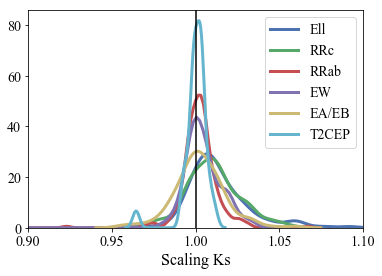

In [147]:
import seaborn as sns
sns.kdeplot(rslts_Ell[:,6],clip=[0,4],label='Ell',lw=3)
sns.kdeplot(rslts_RRc[:,6],clip=[0,4],label='RRc',lw=3)
sns.kdeplot(rslts_RRab[:,6],clip=[0,4],label='RRab',lw=3)
sns.kdeplot(rslts_EW[:,6],clip=[0,4],label='EW',lw=3)
sns.kdeplot(rslts_EAB[:,6],clip=[0,4],label='EA/EB',lw=3)
sns.kdeplot(rslts_T2C[:,6],clip=[0,4],label='T2CEP',lw=3)
plt.axvline(1.,color='k')
plt.xlabel('Scaling Ks')
plt.xlim(0.9,1.1)

(0.5, 1.5)

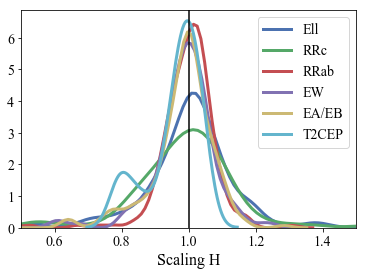

In [149]:
import seaborn as sns
sns.kdeplot(rslts_Ell[:,7],clip=[0,4],label='Ell',lw=3)
sns.kdeplot(rslts_RRc[:,7],clip=[0,4],label='RRc',lw=3)
sns.kdeplot(rslts_RRab[:,7],clip=[0,4],label='RRab',lw=3)
sns.kdeplot(rslts_EW[:,7],clip=[0,4],label='EW',lw=3)
sns.kdeplot(rslts_EAB[:,7],clip=[0,4],label='EA/EB',lw=3)
sns.kdeplot(rslts_T2C[:,7],clip=[0,4],label='T2CEP',lw=3)
plt.axvline(1.,color='k')
plt.xlabel('Scaling H')
plt.xlim(0.5,1.5)

(0.5, 1.5)

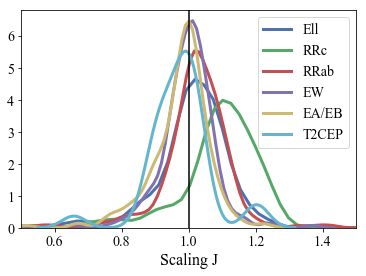

In [150]:
import seaborn as sns
sns.kdeplot(rslts_Ell[:,8],clip=[0,4],label='Ell',lw=3)
sns.kdeplot(rslts_RRc[:,8],clip=[0,4],label='RRc',lw=3)
sns.kdeplot(rslts_RRab[:,8],clip=[0,4],label='RRab',lw=3)
sns.kdeplot(rslts_EW[:,8],clip=[0,4],label='EW',lw=3)
sns.kdeplot(rslts_EAB[:,8],clip=[0,4],label='EA/EB',lw=3)
sns.kdeplot(rslts_T2C[:,8],clip=[0,4],label='T2CEP',lw=3)
plt.axvline(1.,color='k')
plt.xlabel('Scaling J')
plt.xlim(0.5,1.5)

(0.0, 3.0)

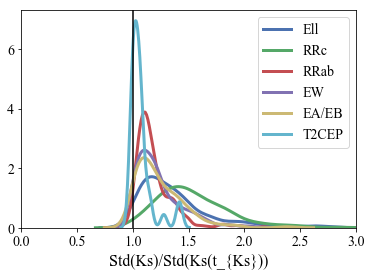

In [151]:
import seaborn as sns
sns.kdeplot(rslts_Ell[:,0],clip=[0,4],label='Ell',lw=3)
sns.kdeplot(rslts_RRc[:,0],clip=[0,4],label='RRc',lw=3)
sns.kdeplot(rslts_RRab[:,0],clip=[0,4],label='RRab',lw=3)
sns.kdeplot(rslts_EW[:,0],clip=[0,4],label='EW',lw=3)
sns.kdeplot(rslts_EAB[:,0],clip=[0,4],label='EA/EB',lw=3)
sns.kdeplot(rslts_T2C[:,0],clip=[0,4],label='T2CEP',lw=3)
plt.axvline(1.,color='k')
plt.xlabel('Std(Ks)/Std(Ks(t_{Ks}))')
plt.xlim(0.,3.)

(0.0, 3.0)

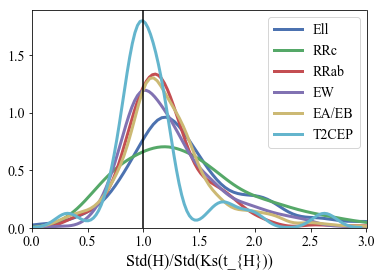

In [152]:
import seaborn as sns
sns.kdeplot(rslts_Ell[:,1],clip=[0,4],label='Ell',lw=3)
sns.kdeplot(rslts_RRc[:,1],clip=[0,4],label='RRc',lw=3)
sns.kdeplot(rslts_RRab[:,1],clip=[0,4],label='RRab',lw=3)
sns.kdeplot(rslts_EW[:,1],clip=[0,4],label='EW',lw=3)
sns.kdeplot(rslts_EAB[:,1],clip=[0,4],label='EA/EB',lw=3)
sns.kdeplot(rslts_T2C[:,1],clip=[0,4],label='T2CEP',lw=3)
plt.axvline(1.,color='k')
plt.xlabel('Std(H)/Std(Ks(t_{H}))')
plt.xlim(0.,3.)

(0.0, 3.0)

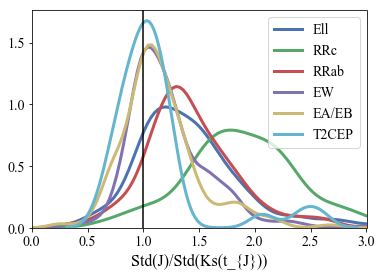

In [153]:
import seaborn as sns
sns.kdeplot(rslts_Ell[:,2],clip=[0,4],label='Ell',lw=3)
sns.kdeplot(rslts_RRc[:,2],clip=[0,4],label='RRc',lw=3)
sns.kdeplot(rslts_RRab[:,2],clip=[0,4],label='RRab',lw=3)
sns.kdeplot(rslts_EW[:,2],clip=[0,4],label='EW',lw=3)
sns.kdeplot(rslts_EAB[:,2],clip=[0,4],label='EA/EB',lw=3)
sns.kdeplot(rslts_T2C[:,2],clip=[0,4],label='T2CEP',lw=3)
plt.axvline(1.,color='k')
plt.xlabel('Std(J)/Std(Ks(t_{J}))')
plt.xlim(0.,3.)

/data/jls/python3.5/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/data/jls/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


(0.0, 3.0)

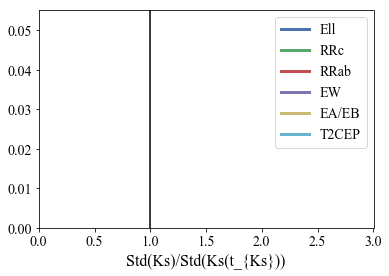

In [156]:
import seaborn as sns
sns.kdeplot(rslts_Ell[:,3],clip=[0,4],label='Ell',lw=3)
sns.kdeplot(rslts_RRc[:,3],clip=[0,4],label='RRc',lw=3)
sns.kdeplot(rslts_RRab[:,3],clip=[0,4],label='RRab',lw=3)
sns.kdeplot(rslts_EW[:,3],clip=[0,4],label='EW',lw=3)
sns.kdeplot(rslts_EAB[:,3],clip=[0,4],label='EA/EB',lw=3)
sns.kdeplot(rslts_T2C[:,3],clip=[0,4],label='T2CEP',lw=3)
plt.axvline(1.,color='k')
plt.xlabel('Std(Ks)/Std(Ks(t_{Ks}))')
plt.xlim(0.,3.)

(0.0, 3.0)

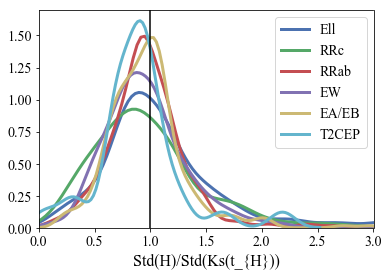

In [155]:
import seaborn as sns
sns.kdeplot(rslts_Ell[:,4],clip=[0,4],label='Ell',lw=3)
sns.kdeplot(rslts_RRc[:,4],clip=[0,4],label='RRc',lw=3)
sns.kdeplot(rslts_RRab[:,4],clip=[0,4],label='RRab',lw=3)
sns.kdeplot(rslts_EW[:,4],clip=[0,4],label='EW',lw=3)
sns.kdeplot(rslts_EAB[:,4],clip=[0,4],label='EA/EB',lw=3)
sns.kdeplot(rslts_T2C[:,4],clip=[0,4],label='T2CEP',lw=3)
plt.axvline(1.,color='k')
plt.xlabel('Std(H)/Std(Ks(t_{H}))')
plt.xlim(0.,3.)

(0.0, 3.0)

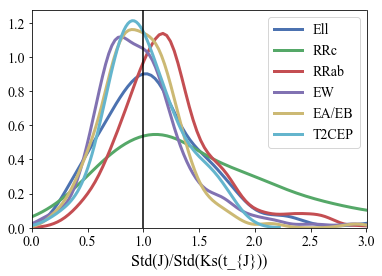

In [154]:
import seaborn as sns
sns.kdeplot(rslts_Ell[:,5],clip=[0,4],label='Ell',lw=3)
sns.kdeplot(rslts_RRc[:,5],clip=[0,4],label='RRc',lw=3)
sns.kdeplot(rslts_RRab[:,5],clip=[0,4],label='RRab',lw=3)
sns.kdeplot(rslts_EW[:,5],clip=[0,4],label='EW',lw=3)
sns.kdeplot(rslts_EAB[:,5],clip=[0,4],label='EA/EB',lw=3)
sns.kdeplot(rslts_T2C[:,5],clip=[0,4],label='T2CEP',lw=3)
plt.axvline(1.,color='k')
plt.xlabel('Std(J)/Std(Ks(t_{J}))')
plt.xlim(0.,3.)

[]

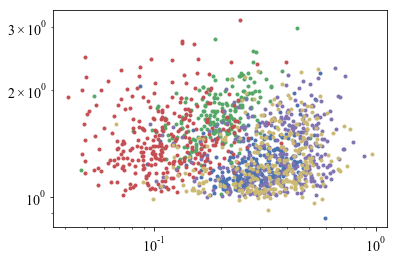

In [146]:
plt.plot(S_RRab['amplitude'],rslts_RRab[:,0],'.')
plt.plot(S_RRc['amplitude'],rslts_RRc[:,0],'.')
plt.plot(S_Ell['amplitude'],rslts_Ell[:,0],'.')
plt.plot(S_EW['amplitude'],rslts_EW[:,0],'.')
plt.plot(S_EAB['amplitude'],rslts_EAB[:,0],'.')
plt.semilogy()
plt.semilogx()

Text(0.5, 0, 'Mean(|H/Ks(t_H)|)')

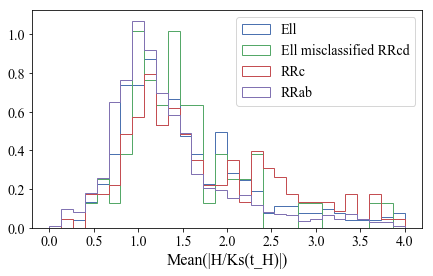

In [29]:
plt.figure(figsize=[7.,4.])
plt.hist(rslts_Ell[:,7][(rslts_Ell[:,4]>5)],bins=30,histtype='step',normed=True,range=[0.,4.],label='Ell');
plt.hist(rslts_Ell[:,7][(S_Ell['var_class']=='Ell')&(S_Ell['class']=='RRcd')&(rslts_Ell[:,4]>5)],
         bins=30,histtype='step',normed=True,range=[0.,4.],label='Ell misclassified RRcd');

plt.hist(rslts_RRc[:,7][rslts_RRc[:,4]>5],bins=30,histtype='step',normed=True,range=[0.,4.],label='RRc');
plt.hist(rslts_RRab[:,7][rslts_RRab[:,4]>5],bins=30,histtype='step',normed=True,range=[0.,4.],label='RRab');
# plt.hist(rslts[:,1],bins=30);
plt.legend()

plt.xlabel('Mean(|H/Ks(t_H)|)')

Text(0.5, 0, 'Mean(|J/Ks(t_J)|)')

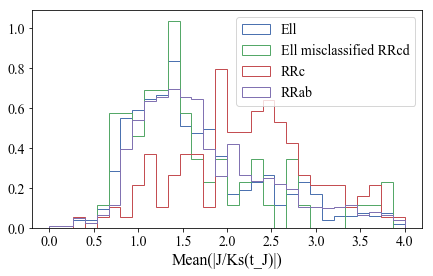

In [30]:
plt.figure(figsize=[7.,4.])
plt.hist(rslts_Ell[:,8][(rslts_Ell[:,5]>5)],bins=30,histtype='step',normed=True,range=[0.,4.],label='Ell');
plt.hist(rslts_Ell[:,8][(S_Ell['var_class']=='Ell')&(S_Ell['class']=='RRcd')&(rslts_Ell[:,5]>5)],
         bins=30,histtype='step',normed=True,range=[0.,4.],label='Ell misclassified RRcd');

plt.hist(rslts_RRc[:,8][rslts_RRc[:,5]>5],bins=30,histtype='step',normed=True,range=[0.,4.],label='RRc');
plt.hist(rslts_RRab[:,8][rslts_RRab[:,5]>5],bins=30,histtype='step',normed=True,range=[0.,4.],label='RRab');
# plt.hist(rslts[:,1],bins=30);
plt.legend()

plt.xlabel('Mean(|J/Ks(t_J)|)')